<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/unibo-intensive-program-2024/blob/main/1-notebooks/chapter-08-01.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Deep Learning in Unsupervised Learning

## Autoencoders

### Introduction

- Autoencoders are a type of artificial neural network used for unsupervised learning of efficient codings, with applications in dimensionality reduction, feature learning, and more recently, generative models. 

- The main goal of an autoencoder is ***to learn a representation (encoding) for a set of data***, typically for the purpose of dimensionality reduction, by training the network to ignore signal “noise.”

### Structure of Autoencoders

An autoencoder consists of tree main parts: the encoder, the latent space and the decoder. 

- **Encoder**: This part of the network compresses the input into a latent-space representation. It encapsulates the inputs into a lower-dimensional code. This process reduces the dimensionality of the data by learning how to ignore non relevant features in the input. 

- **Latent vector**: This is also referred to as latent representation or latent space in some literature. This represents the most important features of the input data in a lower-dimensional form. This is the output provided by the encoder and will be the input for the decoder. The dimension of the latent vector can be bigger than $x$. If so, the autoencoder will simply copy the input to the output. In other words, it will try to memorize the input data. However, in most cases, the dimension of the latent vector is much smaller than $x$.
  
- **Decoder**: After encoding, the decoder part of the network reconstructs the input data from the encoded representation. The aim is to produce an output that matches the input as closely as possible, essentially learning the identity function under certain constraints.

<center>
    
<img src="./pics/ch-08-01-00.jpg" width="500" height="500">
</center>

*An autoencoder consists of 3 components: encoder, code and decoder. The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code.*

- First the input passes through the encoder, which is a fully-connected ANN, to produce the code. The decoder, which has the similar NN structure, then produces the output only using the code. 

- The goal is to get an ***output identical with the input***. 

- Note that the decoder architecture is the mirror image of the encoder. This is not a requirement but it’s typically the case. The only requirement is the dimensionality of the input and output needs to be the same. Anything in the middle can be played with.

<center>
    
<img src="./pics/ch-08-01-01.jpg" width="500" height="500">
</center>


*In the simpler version, both the encoder and decoder are fully-connected feedforward neural networks (but we can have more complicated architecture for example CNN). Code is a single layer of an ANN with the dimensionality of our choice. The number of nodes in the code layer (code size) is a hyperparameter that we set before training the autoencoder.*

- From a more formal point of view, The encoder network receives a $d$-dimensional input feature vector associated with example $x$ (that is, $𝒙 \in \mathbb{R}^d$) and encodes it into a $p$-dimensional vector, $z$ (that is, $𝒛 \in \mathbb{R}^p$ ). 

- In other words, the role of the encoder is to learn how to model the function $𝒛 =f(x)$ . 

- The encoded vector, $z$, is also called the latent vector, or the latent feature representation. 

- Typically, the dimensionality of the latent vector is less than that of the input examples; in other words, $p < d$. Hence, we can say that the encoder acts as a data compression function. 

- Then, the decoder decompresses $\hat x$ from the lower-dimensional latent vector, $z$, where we can think of the decoder as a function, $\hat x = g(z)$.

### Variants of Autoencoders

Autoencoders can be categorized into several types, each with unique characteristics and applications:

- **Basic Autoencoders**: Focus on encoding and decoding input data to learn efficient data codings.
- **Sparse Autoencoders**: Introduce sparsity in the encoded representations to improve robustness and achieve better feature selection.
- **Denoising Autoencoders**: Aim to reconstruct the input from a corrupted version, thus learning to ignore or “denoise” the input.
- **Convolutional Autoencoders**: Utilize convolutional neural networks (CNNs) in the encoder and decoder, making them suitable for image data.
- **Variational Autoencoders (VAEs)**: Incorporate probabilistic layers to model the input distribution, enabling them to generate new data that's similar to the input data.

### Training Autoencoders

- Training an autoencoder involves using backpropagation, just as with other types of neural networks. 

- However, instead of predicting a target value, autoencoders aim to reproduce their inputs. 

- Therefore, the loss function used during training measures the difference between the input and the output (reconstruction loss), such as the mean squared error for continuous input data or cross-entropy for binary input data.

<center>
    
<img src="./pics/ch-08-01-05.jpg" width="500" height="500">
</center>

### Applications of Autoencoders

Autoencoders have a wide range of applications:

- **Dimensionality Reduction**: Similar to PCA but more powerful due to their non-linearity, autoencoders can reduce the dimensionality of data for visualization or preprocessing steps.
- **Feature Learning**: They can learn features from raw data that can be useful for classification tasks or other machine learning applications.
- **Denoising**: Autoencoders can remove noise from data, which is valuable for tasks like image denoising or signal processing.
- **Anomaly Detection**: By learning to reproduce normal data, autoencoders can be used to detect outliers or anomalies in datasets.
- **Generative Models**: Variational autoencoders and their extensions can generate new data that's similar to the training data, useful in domains like drug discovery or creative art generation.

### A simple example

We will use the extremely popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset as input. It contains black-and-white images of handwritten digits.

<center>
    
<img src="./pics/ch-08-01-02.jpg" width="500" height="500">
</center>

They’re of size 28x28 and we use them as a vector of 784 numbers between [0, 1]. We will now implement the autoencoder with Keras. The hyperparameters are: 128 nodes in the hidden layer, code size is 32, and binary crossentropy is the loss function.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from __future__ import print_function
import keras
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

In [2]:
print(keras.backend.backend())

tensorflow


**Utility Functions**

**Plot Encoder Outputs**

The following code defines a function `plot_autoencoder_outputs` that visualizes the outputs of an autoencoder model alongside their original inputs for comparison. This function is particularly useful for assessing the performance of an autoencoder in reconstructing images. It demonstrates how well the autoencoder has learned to compress and then decompress the input data.

This function aims to visually compare the original images from the test dataset (`x_test`) with their reconstructed versions produced by an autoencoder. 
It takes as input:
  - `autoencoder`: The trained autoencoder model.
  - `n`          : The number of images to display.
  - `dims`       : The dimensions to which the images should be reshaped for display (e.g., `(28, 28)` for MNIST).

The function first generates reconstructed images by predicting on the test set with the autoencoder. It then plots `n` examples of original and reconstructed images side by side for easy comparison. This visual comparison helps in understanding how well the autoencoder has learned to capture and reconstruct the essential features of the input images. The use of grayscale color mapping and the removal of axis labels focus attention on the images themselves, making it easier to evaluate the reconstruction quality.

In [3]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    # Predict the outputs for the test set using the trained autoencoder model.
    decoded_imgs = autoencoder.predict(x_test)

    # Set up the figure size for plotting the images.
    plt.figure(figsize=(6, 3))
    for i in range(n):  # Loop over `n` examples to display.
        # Plot original image.
        ax = plt.subplot(2, n, i + 1)  # Create a subplot for the original image.
        plt.imshow(x_test[i].reshape(*dims))  # Reshape and display the original image from the test set.
        plt.gray()  # Use grayscale color map.
        ax.get_xaxis().set_visible(False)  # Hide the x-axis.
        ax.get_yaxis().set_visible(False)  # Hide the y-axis.
        if i == n/2:  # Optionally, set a title for the middle image of the original set.
            ax.set_title('Original Images')

        # Plot reconstructed image.
        ax = plt.subplot(2, n, i + 1 + n)  # Create a subplot for the reconstructed image.
        plt.imshow(decoded_imgs[i].reshape(*dims))  # Reshape and display the decoded (reconstructed) image.
        plt.gray()  # Use grayscale color map.
        ax.get_xaxis().set_visible(False)  # Hide the x-axis.
        ax.get_yaxis().set_visible(False)  # Hide the y-axis.
        if i == n/2:  # Optionally, set a title for the middle image of the reconstructed set.
            ax.set_title('Reconstructed Images')
    
    # Display the plot containing both original and reconstructed images.
    plt.show()


>**NOTE** The `reshape(*dims)` instruction in Python is used to reshape an array into a new shape specified by the `dims` tuple. The asterisk (`*`) before `dims` is the unpacking operator, which is used to unpack the elements of the tuple (or list) `dims` into separate arguments. When you call a function with `*args`, Python unpacks the elements of `args` and passes them to the function as separate positional arguments. This is particularly useful when you want to pass a variable number of arguments to a function or when the shape you want to reshape an array into is stored in a tuple or list.
>
>For example, if `dims` is `(28, 28)`, then `reshape(*dims)` is equivalent to `reshape(28, 28)`. This tells the reshape method to reshape the array into a shape that has 28 rows and 28 columns.
>
>Here's a brief breakdown of how it works:
>- `dims`: A tuple (or list) that specifies the new shape of the array. For instance, if you're working with images like in the >MNIST dataset, `dims` might be `(28, 28)` to represent a 2D image of 28x28 pixels.
>- `*dims`: The unpacking operator `*` is used here to pass the elements of `dims` as separate arguments to the `reshape` >function. This is necessary because the `reshape` method expects each dimension as a separate argument, rather than receiving a >single tuple or list.
>
>This feature of Python makes the code more flexible and readable, especially when the shape dimensions are dynamically determined or if you want to reuse the same shape in multiple places without hardcoding the dimensions each time.

**Plot Compare Histories**

This function, `plot_compare_histories`, is designed to plot the training history of multiple models for comparison. It takes in a list of history objects (typically generated by training models with Keras or a similar framework), a list of names for those models, and an optional flag to indicate whether to plot accuracy or not.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    # Initialize an empty list to store DataFrames
    dflist = []
    # Set the initial minimum number of epochs to the length of epochs of the first history object
    min_epoch = len(history_list[0].epoch)
    # Initialize an empty list to store losses of each model
    losses = []
    
    # Iterate through each history object
    for history in history_list:
        # Extract only the training metrics (not validation metrics) and store them in a dictionary
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        # Convert the dictionary to a DataFrame and append it to the list
        dflist.append(pd.DataFrame(h, index=history.epoch))
        # Update the minimum number of epochs if the current history object has fewer epochs
        min_epoch = min(min_epoch, len(history.epoch))
        # Append the final loss of each model to the losses list
        losses.append(h['loss'][-1])

    # Concatenate the DataFrames horizontally
    historydf = pd.concat(dflist, axis=1)

    # Extract metrics names from the first DataFrame
    metrics = dflist[0].columns
    # Create a MultiIndex for columns with model names and metric names
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    # Assign the MultiIndex to the columns of the concatenated DataFrame
    historydf.columns = idx
    
    # Create a figure for plotting
    plt.figure(figsize=(6, 8))

    # Plot the training loss
    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    # If plot_accuracy flag is True, plot the accuracy
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    # Set the x-axis limit to the minimum number of epochs observed
    plt.xlim(0, min_epoch-1)
    # Adjust layout for better visualization
    plt.tight_layout()


In [5]:
# Load the MNIST dataset. `mnist.load_data()` returns two tuples: one for the 
# training set (x_train, y_train) and one for the test set (x_test, y_test).
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert the pixel values of the images from integers to floating-point numbers.
# This is done to prepare the data for normalization.
x_train = x_train.astype('float32')
x_test  = x_test.astype ('float32')

# Normalize the pixel values of the images to be between 0 and 1.
# This improves the convergence of the model during training.
x_train = x_train / 255.0
x_test  = x_test  / 255.0

In [6]:
# Print some simple infos about the shape of data
print(x_train.shape)
# get the number of "rows"
print(len(x_train))
# get the number of "columns" of first row along second dimension
print(len(x_train[0]))
# get the number of "columns" of first row along third dimension
print(len(x_train[0][0]))
# get the total number of pixel of a single image
print(np.prod(x_train.shape[1:]))

(60000, 28, 28)
60000
28
28
784


In [7]:
# Reshape the training and test data sets so that each image is represented by a single array of pixels.
# Here, `np.prod(x_train.shape[1:])` calculates the product of the dimensions of each image, 
# effectively flattening the image data while keeping the dataset's structure as 
# (number of images, number of pixels per image).
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# Print the shapes of the processed training and test datasets to confirm their dimensions.
# This is useful for debugging and to ensure that the data is correctly formatted for the model.
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In the following cells you find the code to train an autoencoder on the MNIST dataset of handwritten digits, given the input size of 784, which corresponds to the flattened 28x28 pixel images. The autoencoder learns to compress the input images into a 32-dimensional encoded representation and then decode this representation back to images as similar as possible to the original inputs. The training process involves minimizing the difference between the original images and the reconstructed images, using the binary crossentropy loss function. This type of model can be used for feature extraction, noise reduction, or data compression tasks.

**Deep Autoencoder**

In [8]:
# Define the size of the input layer, hidden layer, and the encoded representation (code size).
input_size  = 784  # Typically for flattened 28x28 images from the MNIST dataset.
hidden_size = 128  # Number of neurons in the hidden layer.
code_size   = 32  # Size of the compressed representation.

# Define the input layer with the shape equal to the input size.
input_img   = Input(shape=(input_size,))

# First hidden layer with `hidden_size` neurons and ReLU activation function, connected to the input layer.
hidden_1    = Dense(hidden_size, activation='relu')(input_img)

# The "code" layer that encodes the input image into a compressed representation, with `code_size` neurons.
code        = Dense(code_size, activation='relu')(hidden_1)

# Second hidden layer, which starts the process of decoding the encoded representation, 
# has the same number of neurons as the first hidden layer and uses ReLU activation.
hidden_2    = Dense(hidden_size, activation='relu')(code)

# Output layer that reconstructs the input image from the compressed code, 
# with the same size as the original input and sigmoid activation function for binary output.
output_img  = Dense(input_size, activation='sigmoid')(hidden_2)

# Creation of the autoencoder model, specifying the input and output layers.
autoencoder = Model(input_img, output_img)

# Compile the model with Adam optimizer and binary crossentropy as the loss function.
# This setup is typical for binary input data (e.g., black and white images).
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()
for idx, layer in enumerate(autoencoder.layers):
        print('layer name : ', layer.name,'\t', 'id : ', idx)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
Total params: 209968 (820.19 KB)
Trainable params: 209968 (820.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
layer name :  input_1

In [9]:
# Train the autoencoder using the training data with the input images as both the inputs and targets,
# which is typical for autoencoders since they aim to reconstruct the input.
# Here, the model is trained for n epochs.
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1385
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1007
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0957
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0929
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0909


**Visualization**

Now let’s visualize how well our autoencoder reconstructs its input. We run the autoencoder on the test set simply by using the predict function of Keras. For every image in the test set, we get the output of the autoencoder. We expect the output to be very similar to the input.

313/313 [==============================] - 1s 2ms/step


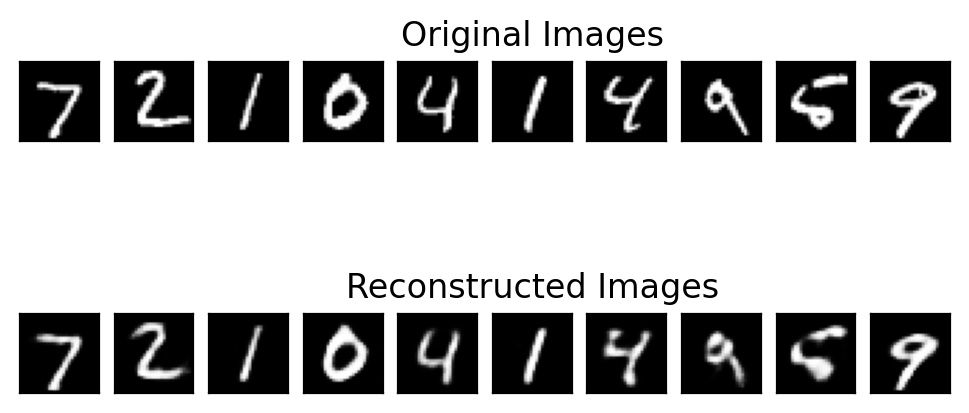

In [10]:
plot_autoencoder_outputs(autoencoder, 10, (28, 28))

**A word of caution**

- We possess full control over the design of the autoencoder, enabling us to enhance its capabilities by adding more layers, increasing the number of nodes in each layer, and, most crucially, expanding the code size. By adjusting these hyperparameters, the autoencoder can capture more complex patterns. 

- However, caution is needed to avoid making it excessively powerful, as it may end up merely duplicating its inputs to the outputs without capturing any significant representations, effectively acting as the identity function. In such cases, the autoencoder would perfectly reconstruct the training data but fail to generalize to new data due to overfitting, which is undesirable.

Hence, we opt for a "sandwich" structure, intentionally maintaining a compact code size. This undercomplete configuration, where the coding layer is of lower dimensionality than the input data, prevents the autoencoder from directly replicating its inputs to the outputs. This limitation compels it to discern and learn meaningful features. For instance, it will recognize and succinctly encode patterns like the linear nature of the digit "1" or the circular shape of "0". An undercomplete autoencoder would struggle to perfectly reconstruct input data that lacks any inherent pattern or correlation. Fortunately, real-world data often contains significant interdependencies, making this approach viable and effective.

**Shallow Autoencoder**

In [11]:
input_size = 784
code_size  = 32

input_img  = Input(shape=(input_size,))
code       = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_4 (Dense)             (None, 32)                25120     
                                                                 
 dense_5 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50992 (199.19 KB)
Trainable params: 50992 (199.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
for idx, layer in enumerate(autoencoder.layers):
        print('layer name : ', layer.name,'\t', 'id : ', idx)

layer name :  input_2 	 id :  0
layer name :  dense_4 	 id :  1
layer name :  dense_5 	 id :  2


In [13]:
autoencoder.fit(x_train, x_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1622
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1039
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0963
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0950
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0945
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0943
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0941
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0940
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0939
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0938


313/313 [==============================] - 1s 3ms/step


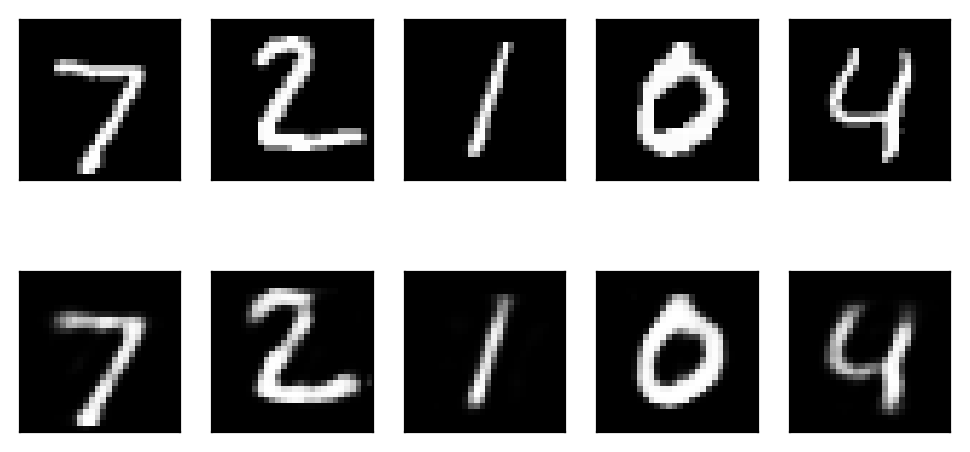

In [14]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

### Denoising Autoencoder

Keeping the code layer small forced our autoencoder to learn an intelligent representation of the data. There is another way to force the autoencoder to learn useful features, which is adding random noise to its inputs and making it recover the original noise-free data. This way the autoencoder can’t simply copy the input to its output because the input also contains random noise. We are asking it to subtract the noise and produce the underlying meaningful data. This is called a denoising autoencoder.

<center>
    
<img src="./pics/ch-08-01-03.jpg" width="500" height="500">
</center>


<center>
    
<img src="./pics/ch-08-01-04.jpg" width="500" height="500">
</center>

*We add random Gaussian noise to them and the noisy data becomes the input to the autoencoder. The autoencoder doesn’t see the original image at all. But then we expect the autoencoder to regenerate the noise-free original image.*

The following code is designed to introduce noise into the training and test datasets and then visualize the effect of this noise on the images. It's a common technique in machine learning, especially in tasks related to image processing, to test the robustness of models against noisy data or to augment the dataset. 

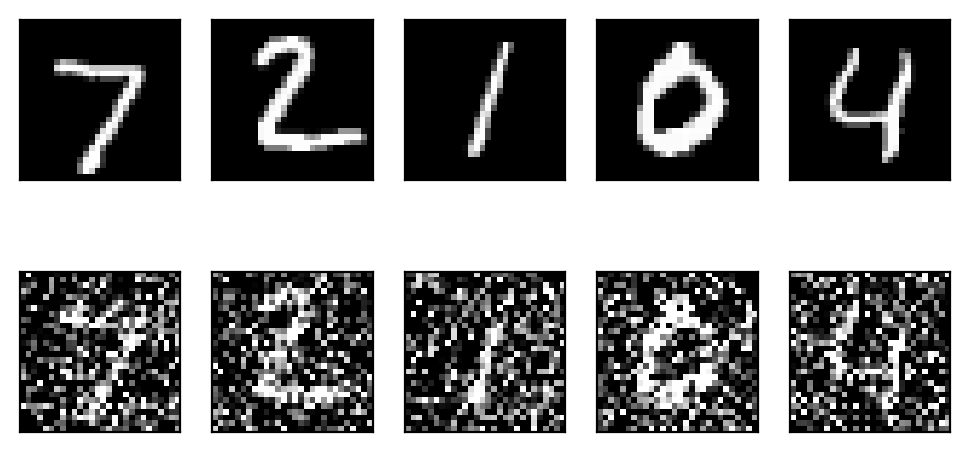

In [18]:
# Introduce a noise factor which determines the magnitude of noise to add to the images.
noise_factor = 0.6

# Add Gaussian noise to the training dataset. The noise is generated with a mean of 0 and a standard deviation of 1,
# multiplied by the noise factor, and added to the original images. This operation is vectorized for efficiency.
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 

# Repeat the process for the test dataset.
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

# Clip the noisy images to ensure their pixel values are within the valid range [0, 1].
# This step is necessary because the addition of noise can lead to values outside this range.
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

# Specify the number of images to display.
n = 5

# Set up the figure for plotting the images.
plt.figure(figsize=(6, 3))

# Loop through the first `n` images to plot them.
for i in range(n):
    # Plot the original image from the test dataset.
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))  # Reshape the image for display.
    plt.gray()                             # Use grayscale for the image.
    ax.get_xaxis().set_visible(False)      # Hide the x-axis.
    ax.get_yaxis().set_visible(False)      # Hide the y-axis.
    if i == n/2:
        ax.set_title('Original Images')    # Optionally, set a title.

    # Plot the corresponding noisy image.
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))  # Reshape the noisy image for display.
    plt.gray()                                   # Use grayscale for the image.
    ax.get_xaxis().set_visible(False)            # Hide the x-axis.
    ax.get_yaxis().set_visible(False)            # Hide the y-axis.
    if i == n/2:
        ax.set_title('Noisy Input')              # Optionally, set a title.


**Implementation of a simple Denoising Autoencoder**

In [19]:
# Define the size of the input layer, hidden layers, and the code (compressed representation)
input_size  = 784  # Typically for a flattened 28x28 image, as used in the MNIST dataset
hidden_size = 128  # Size of the hidden layer
code_size   = 32   # Size of the compressed representation, significantly smaller than the input

# Define the architecture of the autoencoder
input_img  = Input(shape=(input_size,))  # Input layer for the autoencoder
hidden_1   = Dense(hidden_size, activation='relu')(input_img)  # First hidden layer with ReLU activation
code       = Dense(code_size, activation='relu')(hidden_1)  # Compressed representation layer, also with ReLU
hidden_2   = Dense(hidden_size, activation='relu')(code)  # Second hidden layer, helps in decoding
output_img = Dense(input_size, activation='sigmoid')(hidden_2)  # Output layer, same size as input

# Create the autoencoder model by specifying the input and output layers
autoencoder = Model(input_img, output_img)

# Compile the autoencoder model with Adam optimizer and binary crossentropy loss function
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder using noisy input data 'x_train_noisy' and clean target data 'x_train' for 10 epochs
autoencoder.fit(x_train_noisy, x_train, epochs=10)


Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.1844
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1482
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1405
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1367
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1344
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1327
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1314
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1302
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1292
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1283


**Visualization**

313/313 [==============================] - 1s 2ms/step


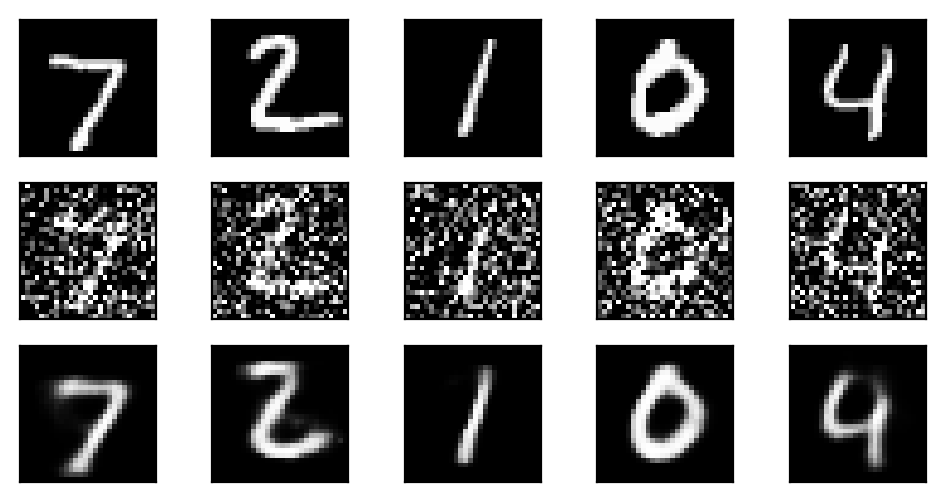

In [20]:
n = 5
plt.figure(figsize=(6, 3))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

### Sparse Autoencoders

- We introduced two ways to force the autoencoder to learn useful features: keeping the code size small and denoising autoencoders. 

- The third method is using regularization. We can regularize the autoencoder by using a sparsity constraint such that only a fraction of the nodes would have nonzero values, called active nodes.

- In particular, we add a penalty term to the loss function such that only a fraction of the nodes become active. This forces the autoencoder to represent each input as a combination of small number of nodes, and demands it to discover interesting structure in the data. This method works even if the code size is large, since only a small subset of the nodes will be active at any time. It’s pretty easy to do this in Keras with just one parameter

In [21]:
# REGULAR AUTOENCODER

input_size = 784
code_size  = 32

input_img  = Input(shape=(input_size,))
code       = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1625
Epoch 2/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1049
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0966
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0951
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0945
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0942
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0940
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0939
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0938
Epoch 10/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0937
Epoch 11/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0936
Epoch 12/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0936
E

We now add another parameter called `activity_regularizer` by specifying the regularization strength. This is typically a value in the range [0.001, 0.000001]. Here we chose $10^{-6}$.

In [22]:
# NORMALIZED AUTOENCODER

# Define the size of the input images and the size of the encoded representation.
input_size = 784  # Assuming a flattened input (e.g., a 28x28 image from MNIST dataset flattened to a 784-dimensional vector).
code_size  = 32   # The dimensionality of the encoded representation.

# Define the input layer of the autoencoder.
input_img = Input(shape=(input_size,))

# Define the encoding layer with `code_size` neurons. Use ReLU activation function.
# `activity_regularizer` is applied to encourage sparsity in the encoded representation,
# which can help in learning more meaningful features. l1 regularization adds a penalty 
# equal to the absolute value of the magnitude of coefficients.
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)

# Define the decoding layer to reconstruct the input from the encoded representation.
# It has the same size as the original input and uses sigmoid activation to output values in [0, 1].
output_img = Dense(input_size, activation='sigmoid')(code)

# Instantiate the autoencoder model with the input and output layers specified.
autoencoder_regularized = Model(input_img, output_img)

# Compile the autoencoder model using Adam optimizer and binary crossentropy loss.
# This setup is typical for binary input data (e.g., pixel values in the range [0, 1]).
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')

In [23]:
# Train the autoencoder on the training data with the input images as both the inputs and targets.
# This is typical for autoencoders since they aim to reconstruct the input data.
# Train for 20 epochs, which determines how many times the learning algorithm will work through the entire training dataset.
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1619
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1065
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0988
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0972
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0966
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0962
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0959
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0957
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0955
Epoch 10/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0954
Epoch 11/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0953
Epoch 12/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0951
E

In [24]:
# Create a separate model to encode input images into the encoded representation.
# This model uses the same input layer as the autoencoder but outputs the encoded representation.
encoded_regularized = Model(input_img, code)

313/313 [==============================] - 1s 3ms/step


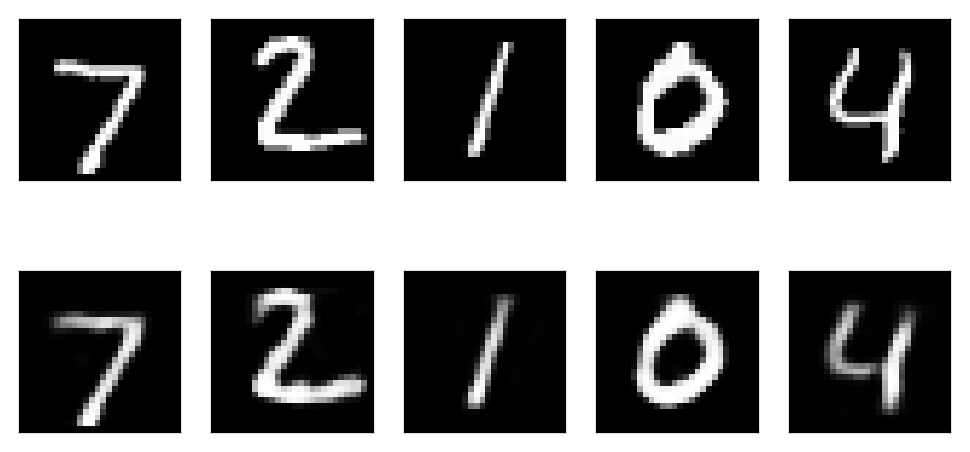

In [25]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

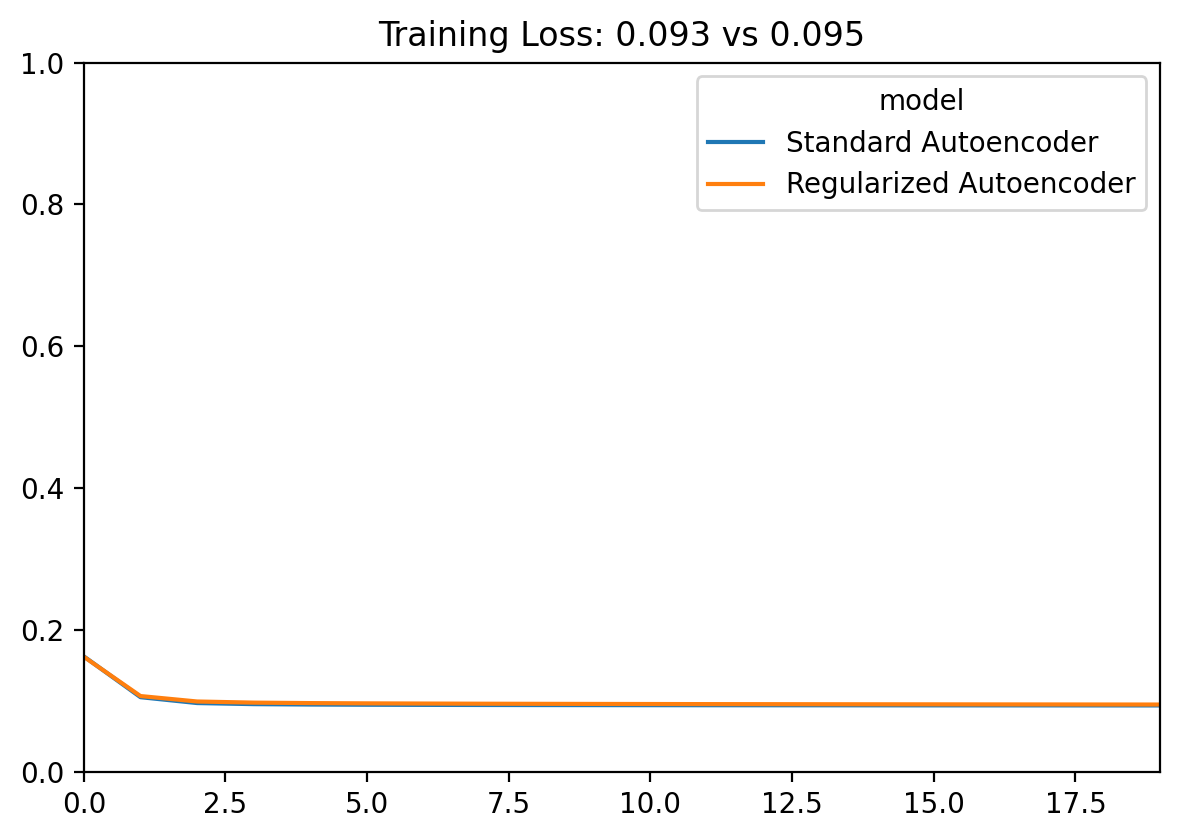

In [26]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [27]:
evaluation_results = autoencoder_standard.evaluate(x_test, x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0922


In [28]:
autoencoder_regularized.evaluate(x_test, x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0938


0.09383250772953033

Let’s demonstrate the encodings generated by the regularized model are indeed sparse. The primary goal of the following code is to compare how the standard and regularized autoencoder models encode the testing data and to visualize the differences in their encoded representations' distributions. Such comparisons can help in understanding the impact of regularization on the model's ability to generalize and compress data. 

By plotting the distributions of the encoded representations, one can infer characteristics such as variance, skewness, and the presence of outliers in the encoded space. Regularization techniques are often employed to ensure that the autoencoder does not overfit the training data and learns a more generalized representation of the input data, which can be crucial for tasks like dimensionality reduction, anomaly detection, and feature learning.

In [29]:
from scipy import stats

esp = encoded_standard.predict(x_test)
erp = encoded_regularized.predict(x_test)

print(esp.shape)
print(erp.shape)

print(esp.mean())
print(erp.mean())

#print(stats.kurtosis(esp))
#print(stats.mode(esp, axis=None).mode)
#print(stats.mode(erp, axis=None).mode)

313/313 [==============================] - 1s 2ms/step
(10000, 32)
(10000, 32)
6.6887064
4.419748


313/313 [==============================] - 1s 2ms/step


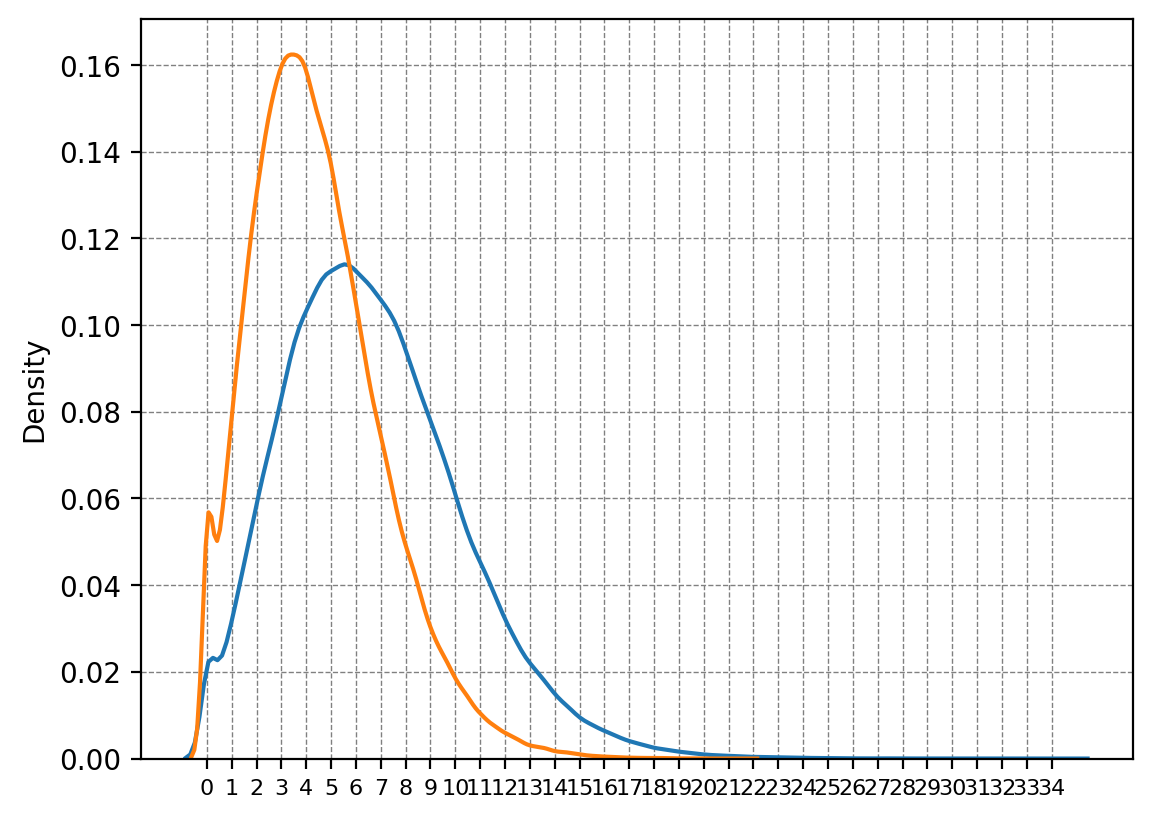

In [30]:
# Predict the encoded representations of the testing data for both the standard and regularized autoencoder models,
# and flatten the results into a 1-dimensional array
standard_scores    = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()

# Plot the distribution of scores generated by the standard autoencoder model using seaborn's distplot function
sns.distplot(standard_scores, hist=False, label='standard model')

# Plot the distribution of scores generated by the regularized autoencoder model using seaborn's distplot function
sns.distplot(regularized_scores, hist=False, label='regularized model')

# Get current axis
ax = plt.gca()

# Set x-axis major ticks to every unit. Adjust the range as necessary.
ax.set_xticks(range(int(min(standard_scores)), int(max(standard_scores)) + 1, 1))

# Enable the grid
plt.grid(True)

# Optionally, you can customize the appearance of the grid
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=8)  # Adjust fontsize as needed for x-axis tick labels
plt.yticks(fontsize=10)  # Adjust fontsize as needed for y-axis tick labels

# Display the plot
plt.show()

**Description**:

- `encoded_standard.predict(x_test)` and `encoded_regularized.predict(x_test)`: These lines predict the encoded representations of the testing data (`x_test`) using the autoencoder models (`encoded_standard` and `encoded_regularized`, respectively). These encoded representations are typically the output of the encoder part of an autoencoder model and are obtained by passing the input data through the encoder network. `ravel()` is then used to flatten the resulting arrays into 1-dimensional arrays, which makes them easier to work with for plotting purposes.

- `sns.distplot(standard_scores, hist=False, label='standard model')`: This line plots the distribution of scores generated by the standard autoencoder model (`standard_scores`). It uses seaborn's `distplot` function to create a kernel density estimation (KDE) plot, which is a smoothed version of the histogram, representing the distribution of data points. The `hist=False` argument specifies that we don't want to plot the histogram along with the KDE. The `label='standard model'` argument assigns a label to this distribution, which will be used in the legend when plotting multiple distributions.

- `sns.distplot(regularized_scores, hist=False, label='regularized model')`: This line plots the distribution of scores generated by the regularized autoencoder model (`regularized_scores`). It uses seaborn's `distplot` function in a similar manner to the previous line, but for the scores generated by the regularized model. The `label='regularized model'` argument assigns a label to this distribution for the legend.

Overall, this code is plotting the distributions of encoded representations (scores) generated by both a standard autoencoder model and a regularized autoencoder model, allowing for a visual comparison of their respective outputs.

## References and Credits

[1] - Dertat A. - ["Applied Deep Learning - Part 3: Autoencoders"](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798), Published in Towards Data Science